# EWT Validation/Testing for EMIT netCDF4 files

To make sure results of the modified functions from ISOFIT, I compared an output from ISOFIT to the same functions when applied to an EMIT netCDF4.

**The wavelengths listed in the ENVI header vs the netcdf file are slightly different, which is causing a difference in the EWT outputs. This difference is larger than I would expect, and seems to result from the least squares fitting of the beer-lambert model.**

In [ ]:
# !pip install "ray[default]"
# !pip install openpyxl

In [1]:
import os
import glob
import earthaccess
import math
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
from osgeo import gdal
import rasterio as rio
import rioxarray as rxr
from matplotlib import pyplot as plt
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
import pandas as pd
import geopandas as gp
import sys
from modules.emit_tools import emit_xarray, ortho_xr
from modules.ewt_calc import calc_ewt
from scipy.optimize import least_squares
from spectral.io import envi

## Download The Granule

In [2]:
# Download Granule
url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230622T193237_2317313_006/EMIT_L2A_RFL_001_20230622T193237_2317313_006.nc'
earthaccess.login(persist=True)
# Get requests https Session using Earthdata Login Info
fs = earthaccess.get_requests_https_session()
# Retrieve granule asset ID from URL (to maintain existing naming convention)
granule_asset_id = url.split('/')[-1]
# Define Local Filepath
fp = f'../data/{granule_asset_id}'
# Download the Granule Asset if it doesn't exist
if not os.path.isfile(fp):
    with fs.get(url,stream=True) as src:
        with open(fp,'wb') as dst:
            for chunk in src.iter_content(chunk_size=64*1024*1024):
                dst.write(chunk)

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 01/12/2024
Using .netrc file for EDL


## Define Functions Taken from ISOFIT for EWT Calculation

In [3]:
# Open ENVI header

# https://github.com/isofit/isofit/blob/dev/isofit/core/common.py#L730C1-L755C34
def envi_header(inputpath):
    """
    Convert a envi binary/header path to a header, handling extensions
    Args:
        inputpath: path to envi binary file
    Returns:
        str: the header file associated with the input reference.

    """
    if (
        os.path.splitext(inputpath)[-1] == ".img"
        or os.path.splitext(inputpath)[-1] == ".dat"
        or os.path.splitext(inputpath)[-1] == ".raw"
    ):
        # headers could be at either filename.img.hdr or filename.hdr.  Check both, return the one that exists if it
        # does, if not return the latter (new file creation presumed).
        hdrfile = os.path.splitext(inputpath)[0] + ".hdr"
        if os.path.isfile(hdrfile):
            return hdrfile
        elif os.path.isfile(inputpath + ".hdr"):
            return inputpath + ".hdr"
        return hdrfile
    elif os.path.splitext(inputpath)[-1] == ".hdr":
        return inputpath
    else:
        return inputpath + ".hdr"

In [4]:
# Functions Used in EWT Calculation from ISOFIT

# https://github.com/isofit/isofit/blob/main/isofit/inversion/inverse_simple.py#L443C1-L511C24
def invert_liquid_water(
    rfl_meas: np.array,
    wl: np.array,
    l_shoulder: float = 850,
    r_shoulder: float = 1100,
    lw_init: tuple = (0.02, 0.3, 0.0002),
    lw_bounds: tuple = ([0, 0.5], [0, 1.0], [-0.0004, 0.0004]),
    ewt_detection_limit: float = 0.5,
    return_abs_co: bool = False,
):
    """Given a reflectance estimate, fit a state vector including liquid water path length
    based on a simple Beer-Lambert surface model.

    Args:
        rfl_meas:            surface reflectance spectrum
        wl:                  instrument wavelengths, must be same size as rfl_meas
        l_shoulder:          wavelength of left absorption feature shoulder
        r_shoulder:          wavelength of right absorption feature shoulder
        lw_init:             initial guess for liquid water path length, intercept, and slope
        lw_bounds:           lower and upper bounds for liquid water path length, intercept, and slope
        ewt_detection_limit: upper detection limit for ewt
        return_abs_co:       if True, returns absorption coefficients of liquid water

    Returns:
        solution: estimated liquid water path length, intercept, and slope based on a given surface reflectance
    """

    # params needed for liquid water fitting
    lw_feature_left = np.argmin(abs(l_shoulder - wl))
    lw_feature_right = np.argmin(abs(r_shoulder - wl))
    wl_sel = wl[lw_feature_left : lw_feature_right + 1]

    # adjust upper detection limit for ewt if specified
    if ewt_detection_limit != 0.5:
        lw_bounds[0][1] = ewt_detection_limit

    # load imaginary part of liquid water refractive index and calculate wavelength dependent absorption coefficient
    # __file__ should live at isofit/isofit/inversion/
    
    
    data_dir_path = "../data/"
    path_k = os.path.join(data_dir_path,"k_liquid_water_ice.xlsx")
    
    #isofit_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
    #path_k = os.path.join(isofit_path, "data", "iop", "k_liquid_water_ice.xlsx")

    k_wi = pd.read_excel(io=path_k, sheet_name="Sheet1", engine="openpyxl")
    wl_water, k_water = get_refractive_index(
        k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C"
    )
    kw = np.interp(x=wl_sel, xp=wl_water, fp=k_water)
    abs_co_w = 4 * np.pi * kw / wl_sel

    rfl_meas_sel = rfl_meas[lw_feature_left : lw_feature_right + 1]

    x_opt = least_squares(
        fun=beer_lambert_model,
        x0=lw_init,
        jac="2-point",
        method="trf",
        bounds=(
            np.array([lw_bounds[ii][0] for ii in range(3)]),
            np.array([lw_bounds[ii][1] for ii in range(3)]),
        ),
        max_nfev=15,
        args=(rfl_meas_sel, wl_sel, abs_co_w),
    )

    solution = x_opt.x

    if return_abs_co:
        return solution, abs_co_w
    else:
        return solution

# https://github.com/isofit/isofit/blob/main/isofit/inversion/inverse_simple.py#L514C1-L532C17
def beer_lambert_model(x, y, wl, alpha_lw):
    """Function, which computes the vector of residuals between measured and modeled surface reflectance optimizing
    for path length of surface liquid water based on the Beer-Lambert attenuation law.

    Args:
        x:        state vector (liquid water path length, intercept, slope)
        y:        measurement (surface reflectance spectrum)
        wl:       instrument wavelengths
        alpha_lw: wavelength dependent absorption coefficients of liquid water

    Returns:
        resid: residual between modeled and measured surface reflectance
    """

    attenuation = np.exp(-x[0] * 1e7 * alpha_lw)
    rho = (x[1] + x[2] * wl) * attenuation
    resid = rho - y

    return resid

# https://github.com/isofit/isofit/blob/dev/isofit/core/common.py#L461C1-L488C26
def get_refractive_index(k_wi, a, b, col_wvl, col_k):
    """Convert refractive index table entries to numpy array.

    Args:
        k_wi:    variable
        a:       start line
        b:       end line
        col_wvl: wavelength column in pandas table
        col_k:   k column in pandas table

    Returns:
        wvl_arr: array of wavelengths
        k_arr:   array of imaginary parts of refractive index
    """

    wvl_ = []
    k_ = []

    for ii in range(a, b):
        wvl = k_wi.at[ii, col_wvl]
        k = k_wi.at[ii, col_k]
        wvl_.append(wvl)
        k_.append(k)

    wvl_arr = np.asarray(wvl_)
    k_arr = np.asarray(k_)

    return wvl_arr, k_arr

## Open EMIT .nc and ISOFIT ewt ENVI output

In [5]:
# Filepaths
fp = "../data/EMIT_L2A_RFL_001_20230622T193237_2317313_006.nc"
fp_envi_ewt = "../data/emit20230622t193237_2317313_006_ewt"

In [6]:
# Open ENVI EWT
ewt_ds = envi.open(envi_header(fp_envi_ewt))
ewt_array = ewt_ds[:,:]
# Get Wavelengths from ENVI header
envi_wvl = np.array([float(x) for x in ewt_ds.metadata["wavelength"]])

In [7]:
# Open netCDF and get reflectance array and wl array
rfl = np.array(nc.Dataset(fp)['reflectance'][:])
wvl = np.array(nc.Dataset(fp)['sensor_band_parameters']['wavelengths'][:])

There is a slight difference between wavelenghts that looks like rounding

In [8]:
# Get differences between wavelengths
d_wl = pd.DataFrame.from_dict({"nc_wvl":wvl,"envi_wvl":envi_wvl,"diff":(wvl-envi_wvl)})
#d_wl.to_csv("wvl_differences.csv")
d_wl.head()

,nc_wvl,envi_wvl,diff
0,381.005585,381.005593,-0.000008
1,388.409210,388.409208,0.000002
2,395.815826,395.815814,0.000012
3,403.225403,403.225411,-0.000008
4,410.638000,410.637999,0.000001


## Show ISOFIT Calculated EWT at a Point

In [9]:
point = 1180,1142
point

(1180, 1142)

In [10]:
# Isofit Calculated EWT at a Point
ewt_array[point]

array([0.15730211], dtype=float32)

## Calculate EWT using the netCDF4 wavelengths

In [11]:
ewt_single_nc_wvl = invert_liquid_water(rfl[point],wvl,ewt_detection_limit=.5, return_abs_co=True)

In [12]:
## Calculate EWT using the ENVI wavelengths

In [13]:
ewt_single_envi_wvl = invert_liquid_water(rfl[point],envi_wvl,ewt_detection_limit=.5, return_abs_co=True)

In [14]:
## Compare EWT Values at Point

In [15]:
ewt_single_nc_wvl[0][0]

0.047153029730229064

In [16]:
ewt_single_envi_wvl[0][0]

0.15730211263591012

When using the envi header wavelengths, this value is really close to isofit output

## Compare Absorption Coefficients 

In [17]:
ewt_single_nc_wvl[1]

array([4.14394069e-09, 4.35188225e-09, 4.56165031e-09, 4.84588806e-09,
       5.21900209e-09, 5.65208884e-09, 6.06520654e-09, 6.50566492e-09,
       7.07461141e-09, 8.17247955e-09, 1.01237322e-08, 1.36298311e-08,
       1.85431820e-08, 2.54684197e-08, 3.64647587e-08, 4.48321905e-08,
       4.71053962e-08, 4.76000482e-08, 4.63649869e-08, 4.38354265e-08,
       4.04134315e-08, 3.65827227e-08, 3.24228595e-08, 2.82215980e-08,
       2.43130882e-08, 2.10288509e-08, 1.83584628e-08, 1.61802035e-08,
       1.48940269e-08, 1.42999765e-08, 1.42980130e-08, 1.49440772e-08,
       1.61800178e-08, 1.80719746e-08])

In [18]:
ewt_single_envi_wvl[1]

array([4.14394035e-09, 4.35188261e-09, 4.56165116e-09, 4.84588831e-09,
       5.21900138e-09, 5.65208927e-09, 6.06520648e-09, 6.50566447e-09,
       7.07461084e-09, 8.17247937e-09, 1.01237352e-08, 1.36298471e-08,
       1.85431726e-08, 2.54684122e-08, 3.64648050e-08, 4.48321837e-08,
       4.71053909e-08, 4.76000482e-08, 4.63649916e-08, 4.38354383e-08,
       4.04134190e-08, 3.65827094e-08, 3.24228519e-08, 2.82216133e-08,
       2.43130992e-08, 2.10288572e-08, 1.83584614e-08, 1.61801967e-08,
       1.48940318e-08, 1.42999765e-08, 1.42980165e-08, 1.49440753e-08,
       1.61800250e-08, 1.80719705e-08])

The absorption coefficient also varies slightly as a result of the difference in wavelengths

In [19]:
(ewt_single_nc_wvl[1] == ewt_single_envi_wvl[1])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [20]:
#Check RFL_MEAS_SEL
rfl_meas=rfl[1180,1142,:]
wl=wvl
l_shoulder= 850,
r_shoulder= 1100,
lw_feature_left = np.argmin(abs(l_shoulder - wl))
lw_feature_right = np.argmin(abs(r_shoulder - wl))
wl_sel = wl[lw_feature_left : lw_feature_right + 1]
rfl_meas_sel = rfl_meas[lw_feature_left : lw_feature_right + 1]
wl_sel, rfl_meas_sel

(array([ 850.1313 ,  857.5937 ,  865.0551 ,  872.5176 ,  879.98004,
         887.44147,  894.90393,  902.3664 ,  909.82886,  917.2913 ,
         924.7538 ,  932.21625,  939.6788 ,  947.14026,  954.6027 ,
         962.0643 ,  969.5268 ,  976.9883 ,  984.4498 ,  991.9114 ,
         999.37286, 1006.8344 , 1014.295  , 1021.7566 , 1029.2172 ,
        1036.6777 , 1044.1383 , 1051.5989 , 1059.0596 , 1066.5201 ,
        1073.9797 , 1081.4404 , 1088.9    , 1096.3597 ], dtype=float32),
 array([0.25256753, 0.25427166, 0.25593334, 0.25743258, 0.258818  ,
        0.26004905, 0.26071286, 0.261594  , 0.2625632 , 0.26349127,
        0.2643549 , 0.26297614, 0.26182526, 0.2614127 , 0.26008645,
        0.2592331 , 0.2598713 , 0.26125658, 0.26356116, 0.26583087,
        0.26886293, 0.27228928, 0.27545962, 0.27871832, 0.2819384 ,
        0.28498363, 0.28784767, 0.29042587, 0.29259545, 0.29443958,
        0.2961391 , 0.29754463, 0.29846248, 0.29868984], dtype=float32))

In [21]:
rfl_meas=rfl[1180,1142,:]
wl=envi_wvl
l_shoulder= 850,
r_shoulder= 1100,
lw_feature_left = np.argmin(abs(l_shoulder - wl))
lw_feature_right = np.argmin(abs(r_shoulder - wl))
wl_sel_envi = wl[lw_feature_left : lw_feature_right + 1]
rfl_meas_sel_envi = rfl_meas[lw_feature_left : lw_feature_right + 1]
wl_sel_envi, rfl_meas_sel_envi

(array([ 850.1312753,  857.5937073,  865.0551432,  872.5175831,
         879.9800273,  887.441476 ,  894.9039293,  902.3663876,
         909.8288511,  917.2913198,  924.7537941,  932.2162742,
         939.6787602,  947.1402525,  954.6027511,  962.0642563,
         969.5267683,  976.9882874,  984.4498137,  991.9113475,
         999.3728889, 1006.8344382, 1014.2949956, 1021.7565613,
        1029.2171354, 1036.6777184, 1044.1383102, 1051.5989112,
        1059.0595215, 1066.5201414, 1073.9797711, 1081.4404108,
        1088.9000607, 1096.359721 ]),
 array([0.25256753, 0.25427166, 0.25593334, 0.25743258, 0.258818  ,
        0.26004905, 0.26071286, 0.261594  , 0.2625632 , 0.26349127,
        0.2643549 , 0.26297614, 0.26182526, 0.2614127 , 0.26008645,
        0.2592331 , 0.2598713 , 0.26125658, 0.26356116, 0.26583087,
        0.26886293, 0.27228928, 0.27545962, 0.27871832, 0.2819384 ,
        0.28498363, 0.28784767, 0.29042587, 0.29259545, 0.29443958,
        0.2961391 , 0.29754463, 0.29846248

In [22]:
(rfl_meas_sel == rfl_meas_sel_envi).all()

True

In [23]:
# Check KW
rfl_meas=rfl[1180,1142,:]
wl=wvl
l_shoulder= 850,
r_shoulder= 1100,
lw_feature_left = np.argmin(abs(l_shoulder - wl))
lw_feature_right = np.argmin(abs(r_shoulder - wl))
wl_sel = wl[lw_feature_left : lw_feature_right + 1]
ewt_detection_limit= 0.5

# adjust upper detection limit for ewt if specified
if ewt_detection_limit != 0.5:
    lw_bounds[0][1] = ewt_detection_limit

# load imaginary part of liquid water refractive index and calculate wavelength dependent absorption coefficient
# __file__ should live at isofit/isofit/inversion/


data_dir_path = "../data/"
path_k = os.path.join(data_dir_path,"k_liquid_water_ice.xlsx")

#isofit_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
#path_k = os.path.join(isofit_path, "data", "iop", "k_liquid_water_ice.xlsx")

k_wi = pd.read_excel(io=path_k, sheet_name="Sheet1", engine="openpyxl")
wl_water, k_water = get_refractive_index(
    k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C"
)
kw_nc= np.interp(x=wl_sel, xp=wl_water, fp=k_water)
kw_nc

array([2.80342968e-07, 2.96994802e-07, 3.14018984e-07, 3.36463299e-07,
       3.65468902e-07, 3.99152481e-07, 4.31928784e-07, 4.67159021e-07,
       5.12215166e-07, 5.96556062e-07, 7.45001076e-07, 1.01110738e-06,
       1.38660836e-06, 1.91958095e-06, 2.77004069e-06, 3.43229163e-06,
       3.63429865e-06, 3.70072559e-06, 3.63223439e-06, 3.46009676e-06,
       3.21398183e-06, 2.93105664e-06, 2.61701208e-06, 2.29466444e-06,
       1.99130269e-06, 1.73480014e-06, 1.52540258e-06, 1.35401735e-06,
       1.25522812e-06, 1.21365296e-06, 1.22197385e-06, 1.28606181e-06,
       1.40202945e-06, 1.57669911e-06])

In [24]:
# Check KW
rfl_meas=rfl[1180,1142,:]
wl=envi_wvl
l_shoulder= 850,
r_shoulder= 1100,
lw_feature_left = np.argmin(abs(l_shoulder - wl))
lw_feature_right = np.argmin(abs(r_shoulder - wl))
wl_sel = wl[lw_feature_left : lw_feature_right + 1]
ewt_detection_limit= 0.5

# adjust upper detection limit for ewt if specified
if ewt_detection_limit != 0.5:
    lw_bounds[0][1] = ewt_detection_limit

# load imaginary part of liquid water refractive index and calculate wavelength dependent absorption coefficient
# __file__ should live at isofit/isofit/inversion/


data_dir_path = "../data/"
path_k = os.path.join(data_dir_path,"k_liquid_water_ice.xlsx")

#isofit_path = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
#path_k = os.path.join(isofit_path, "data", "iop", "k_liquid_water_ice.xlsx")

k_wi = pd.read_excel(io=path_k, sheet_name="Sheet1", engine="openpyxl")
wl_water, k_water = get_refractive_index(
    k_wi=k_wi, a=0, b=982, col_wvl="wvl_6", col_k="T = 20°C"
)
kw_envi= np.interp(x=wl_sel, xp=wl_water, fp=k_water)

In [25]:
kw_envi == kw_nc

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [26]:
# Test Single Pixel
point = rfl[1180,1142,:]

In [27]:
ewt_single = invert_liquid_water(point,wvl,ewt_detection_limit=0.5)
ewt_single

array([ 4.71530297e-02,  3.00000000e-01, -2.54655160e-05])

In [28]:
ewt_array[1180,1142,:]

array([0.15730211], dtype=float32)

## Open EMIT netCDF4 and crop for a test

In [29]:
# # Open EMIT DS
# ds = emit_xarray(fp)
# ds

In [30]:
# cropped_ds = ds.sel(downtrack=slice(1180,1280),crosstrack=slice(1142,1242))
# cropped_ds.to_netcdf("../data/cropped_cwc_test.nc")

In [31]:
cropped_ds = xr.open_dataset("../data/cropped_cwc_test.nc")
cropped_ds

<xarray.Dataset>
Dimensions:           (downtrack: 100, crosstrack: 100, wavelengths: 285,
                       ortho_y: 1998, ortho_x: 2250)
Coordinates:
  * downtrack         (downtrack) int64 1180 1181 1182 1183 ... 1277 1278 1279
  * crosstrack        (crosstrack) int64 1142 1143 1144 1145 ... 1239 1240 1241
    lon               (downtrack, crosstrack) float64 ...
    lat               (downtrack, crosstrack) float64 ...
    elev              (downtrack, crosstrack) float64 ...
    glt_x             (ortho_y, ortho_x) float64 ...
    glt_y             (ortho_y, ortho_x) float64 ...
  * wavelengths       (wavelengths) float32 381.0 388.4 ... 2.486e+03 2.493e+03
    fwhm              (wavelengths) float32 ...
    good_wavelengths  (wavelengths) float32 ...
Dimensions without coordinates: ortho_y, ortho_x
Data variables:
    reflectance       (downtrack, crosstrack, wavelengths) float32 ...
Attributes: (12/39)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatialResolution:                 0.000542232520256367
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.19898189e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20230622T193237_23173...

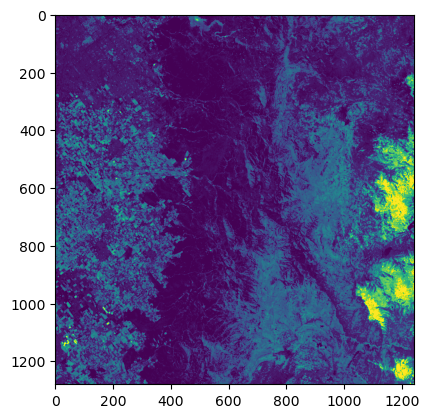

In [32]:
plt.imshow(ewt_array)

Text(0.5, 1.0, 'ISOFIT Output')

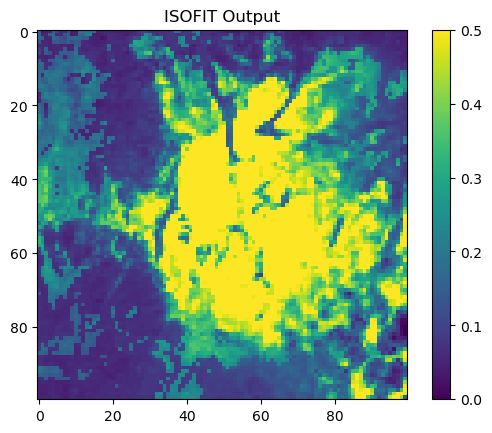

In [34]:
# Plot of ENVI WL EWT
plt.imshow(ewt_array[1180:,1142:,:])
plt.colorbar()
plt.title("ISOFIT Output")

## Run EWT Calc using netCDF4 wavelengths

In [33]:
# Run EWT Calc for netcdf4 wavelengths
cwc = calc_ewt("../data/cropped_cwc_test.nc", "../data/",wl=wvl, ewt_detection_limit=0.5)

2023-11-14 00:36:26,691	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-11-14 00:36:26,826	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Text(0.5, 1.0, 'EWT Calculated with netcdf4 WL')

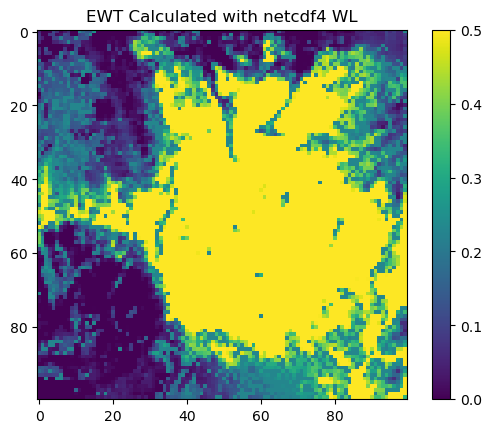

In [35]:
plt.imshow(cwc)
plt.colorbar()
plt.title("EWT Calculated with netcdf4 WL")

In [36]:
diff = (cwc - ewt_array[1180:,1142:,:])

Text(0.5, 1.0, 'Difference, NetCDF4 WL Calculated EWT - ISOFIT Output')

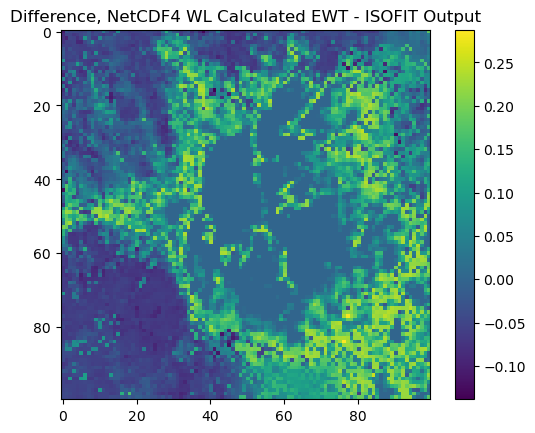

In [37]:
plt.imshow(diff)
plt.colorbar()
plt.title("Difference, NetCDF4 WL Calculated EWT - ISOFIT Output")

## Calculated EWT for Area using ENVI Header Wavelengths

In [38]:
envi_cwc = calc_ewt("../data/cropped_cwc_test.nc", "../data/",wl=envi_wvl, ewt_detection_limit=0.5)

2023-11-14 00:37:34,433	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-11-14 00:37:34,571	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Text(0.5, 1.0, 'EWT Calculated with netcdf4 WL')

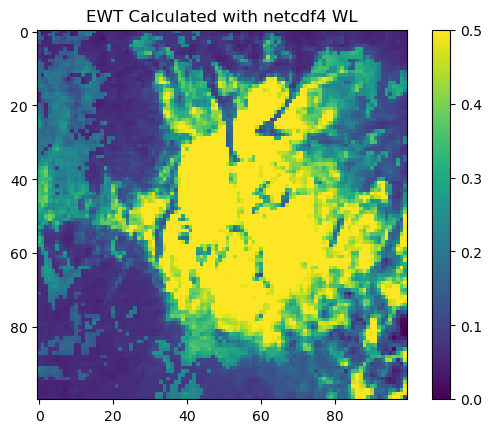

In [39]:
plt.imshow(envi_cwc)
plt.colorbar()
plt.title("EWT Calculated with netcdf4 WL")

In [40]:
envi_diff = (envi_cwc - ewt_array[1180:,1142:,:])

Text(0.5, 1.0, 'Difference, ENVI WL Calculated EWT - ISOFIT Output')

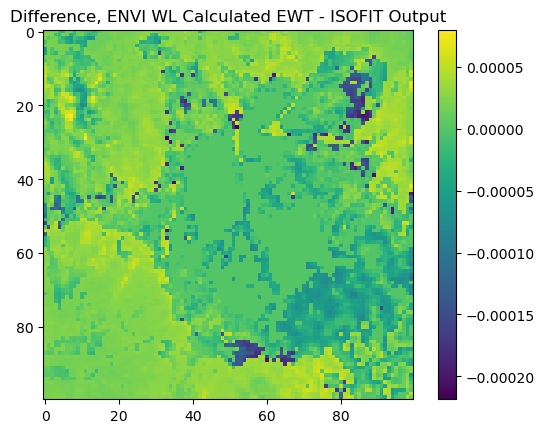

In [41]:
plt.imshow(envi_diff)
plt.colorbar()
plt.title("Difference, ENVI WL Calculated EWT - ISOFIT Output")